# Optical Image Processing System

The following is an image processing program used to track and determine characteristics of cell movement including velocity and angle.

## Setup the Project:

In [1]:
from __future__ import division, unicode_literals, print_function
import os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc("figure", figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np 
import pandas as pd
from pandas import DataFrame, Series

In [3]:
import pims
import trackpy as tp
import collections
import xlsxwriter

## Read data and convert to grayscale

#### Import the path for your AVI video below inbetween the quotes:

In [4]:
#video_path = '/Users/ashty/Downloads/testcells.avi'
video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/14-x2-2.avi'
#video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/18-3xbfafter2.avi'
#video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/18-3xbfbefore2.avi'

In [5]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]

if os.path.exists(video_path):
    frames = gray(pims.Video(video_path))
    print('Video loaded successfully!')
else: 
    print('Video fild not found:', video_path)

Video loaded successfully!


In [6]:
frames

(ImageIOReader,) processed through proc_func. Original repr:
    <FramesSequenceND>
    Axes: 3
    Axis 'x' size: 1024
    Axis 'y' size: 768
    Axis 't' size: 127
    Pixel Datatype: uint8

## Show the first frame

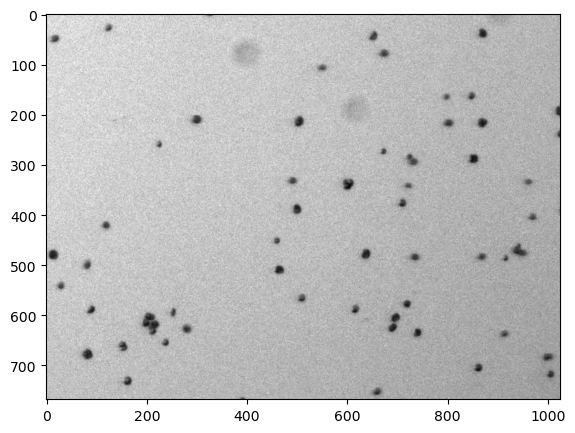

In [7]:
plt.imshow(frames[0])

## Locate cells

#### The second number in the parenthesis is an estimate of cell size in pixels. It needs to be an odd integer.

In [8]:
f = tp.locate(frames[0], 21, invert=True)

In [9]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,11.266777,616.485149,736.477014,6.747244,0.255878,17.014320,20162.0,NaN,0
1,11.416907,644.435159,843.424171,6.582879,0.234655,13.368395,20887.0,NaN,0
2,15.405177,972.048396,719.867797,6.738462,0.148458,12.153086,25113.0,NaN,0
3,9.407025,208.592459,784.279153,6.356449,0.102552,13.368395,15949.0,NaN,0
4,12.216863,908.390353,999.388775,6.658744,0.034992,14.178600,29797.0,NaN,0


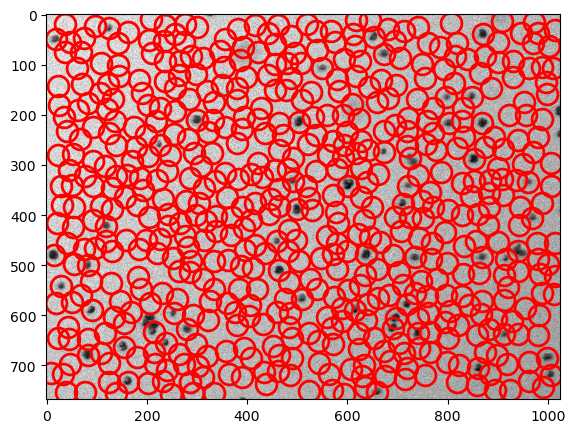

In [10]:
tp.annotate(f, frames[0]);

## Filter based on brightness

#### The plot of cell count versus mass

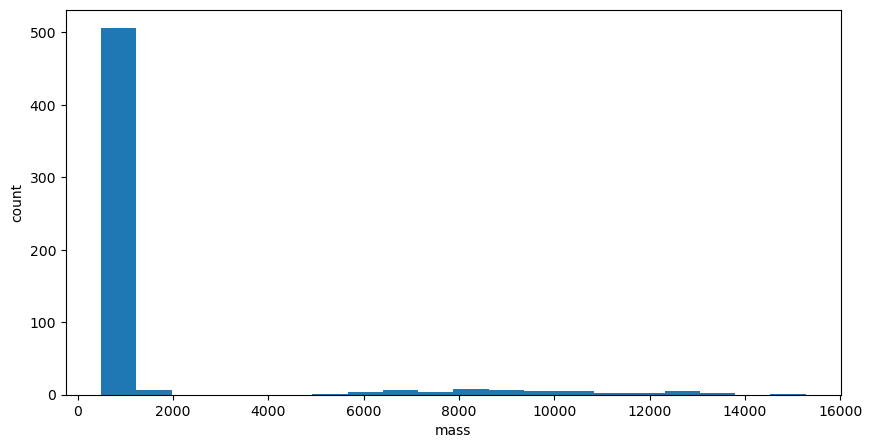

In [11]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

ax.set(xlabel='mass', ylabel='count');

#### Now apply the minimum mass parameter based on the plot

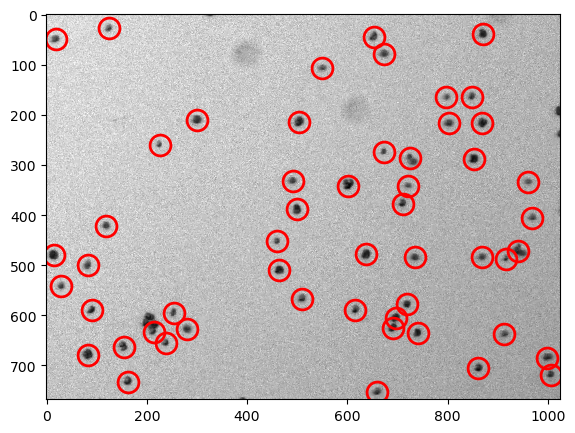

In [12]:
f = tp.locate(frames[0], 21, invert=True, minmass=2000)
tp.annotate(f, frames[0]);

## Check for Subpixel Accuracy in 

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

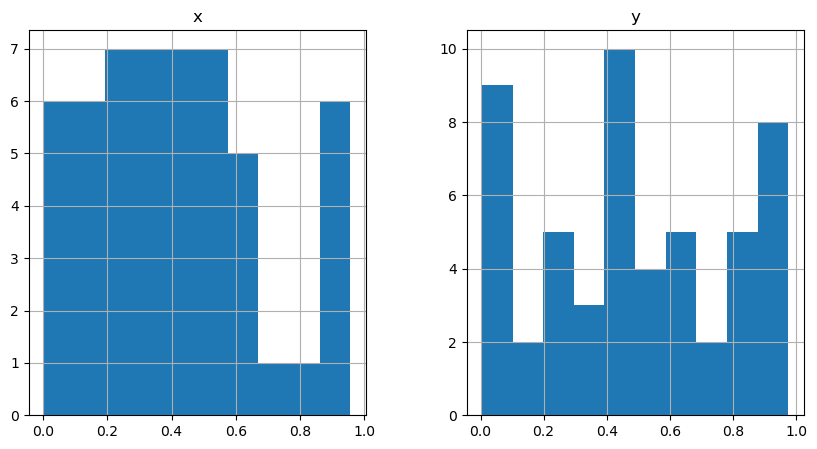

In [13]:
tp.subpx_bias(f)

## Collect data from set of frames into a table

#### Plug in the number of frames you would like to collect data from

In [14]:
f = tp.batch(frames[:150], 21, minmass=2000, invert=True,processes=1);

Frame 126: 50 features


## Link located cells into particle trajectories

In [15]:
t = tp.link(f, 10, memory=3)

Frame 126: 50 trajectories present.


In [16]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,27.605863,124.647954,8277.061800,4.743788,0.168155,96.009380,34233.0,NaN,0,0
29,484.592789,734.901379,8404.264100,5.160118,0.120143,70.487899,47624.0,NaN,0,1
30,487.271536,915.525288,5102.270623,4.051818,0.145042,90.337940,39735.0,NaN,0,2
31,500.476351,82.214073,9395.550818,5.236938,0.141124,84.666499,42286.0,NaN,0,3
32,509.827236,464.556254,13210.809630,5.761829,0.084927,84.666499,55089.0,NaN,0,4


### Display a walk through

#### Let us display the program locating one cell and assigning an ID number to the cell

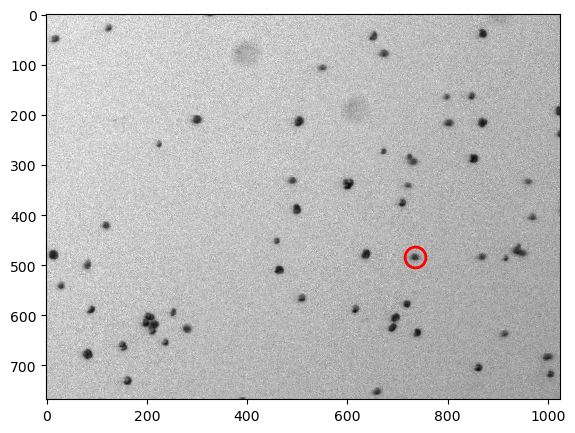

In [17]:
particle_id = 1;
p=t[t['particle']==particle_id]
q=p[p['frame']==0]
tp.annotate(q, frames[0]);

#### Now let us display the tracking locations for all the frames throughout the entirety of the video

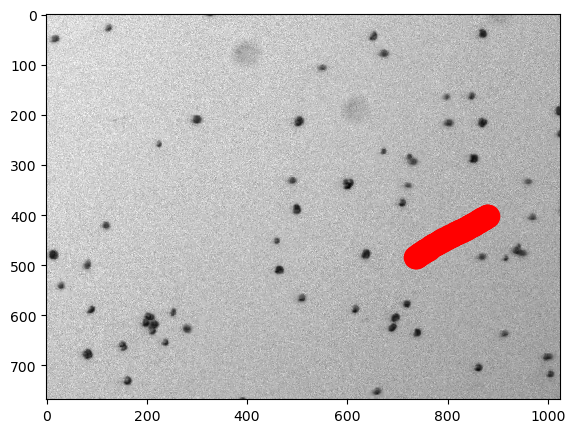

In [18]:
particle_id =1 ;
p=t[t['particle']==particle_id]
tp.annotate(p, frames[0]);

## Filter Trajectories

#### Keep only the trajectories that last a certain number of frames 

In [20]:
t1=t.copy()

#### Compare the # of trajectories before and after filtering

In [21]:
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 613
After: 613


## Filter based on particles' appearance

#### Plot mass vs. size of particles

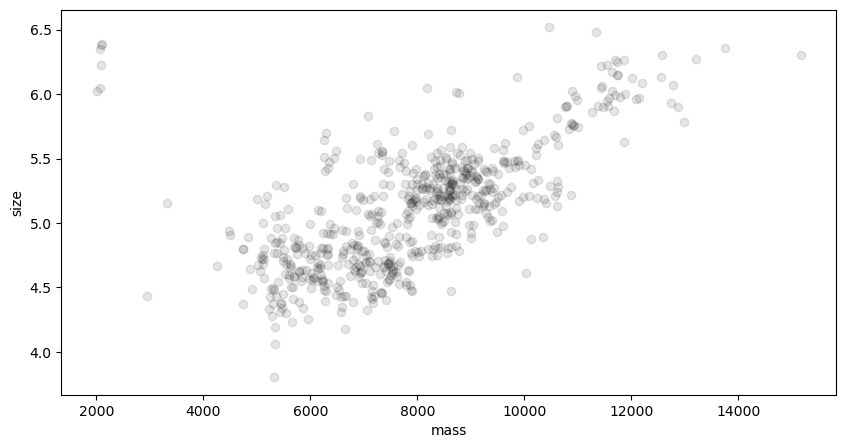

In [22]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean());

#### Now apply the filter based on the mass, size, and eccentricity

In [23]:
t2 = t1[((t1['mass'] > 2000) & (t1['size'] < 8) & (t1['ecc'] < 5))]

## Plot the filtered trajectories

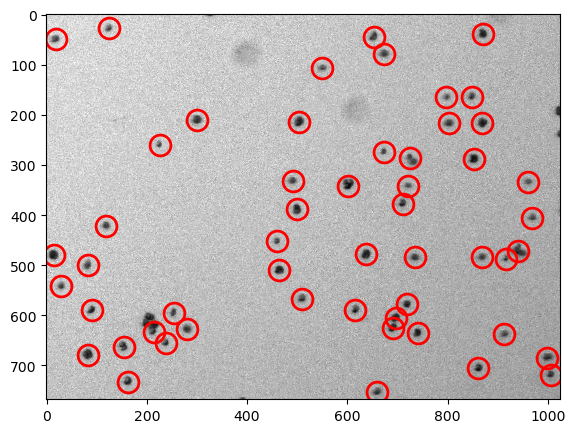

<Axes: >

In [24]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

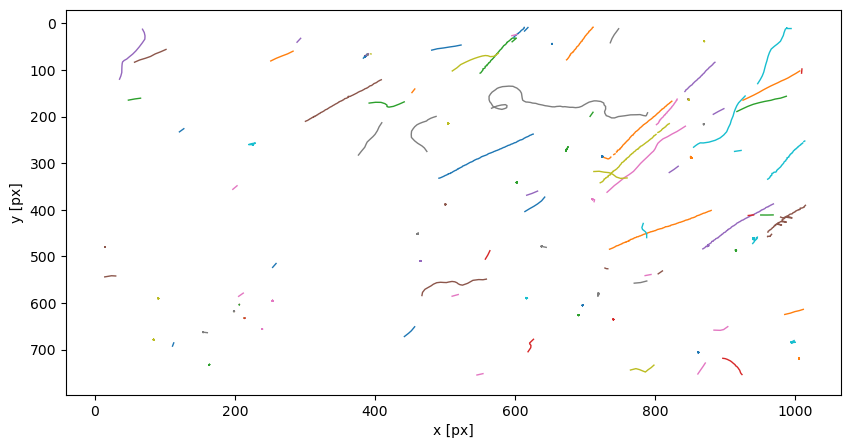

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [25]:
plt.figure()
tp.plot_traj(t2)

#### Save first set of data to an excel file. Title the excel file per video. 

In [26]:
excel_file = pd.ExcelWriter('Cell_Movement_18x3.xlsx', engine='xlsxwriter')
workbook=excel_file.book
worksheet=workbook.add_worksheet('Trajectory Data')
t2.to_excel(excel_file, sheet_name='Trajectory Data', index=False)

In [27]:
print(t2)

               y           x          mass      size       ecc     signal   
0      27.605863  124.647954   8277.061800  4.743788  0.168155  96.009380  \
29    484.592789  734.901379   8404.264100  5.160118  0.120143  70.487899   
30    487.271536  915.525288   5102.270623  4.051818  0.145042  90.337940   
31    500.476351   82.214073   9395.550818  5.236938  0.141124  84.666499   
32    509.827236  464.556254  13210.809630  5.761829  0.084927  84.666499   
...          ...         ...           ...       ...       ...        ...   
6277  373.357273  607.667053   5240.551965  4.422667  0.145343  73.279272   
6278  388.962183  500.769587  13094.008625  5.942107  0.133880  89.756268   
6279  387.413604  968.957220   7267.222483  5.092000  0.123835  64.607169   
6268  216.635942  869.669195  12061.594738  6.001638  0.096941  75.880903   
6307  732.704085  163.253131  10560.453674  5.657079  0.175608  84.986611   

      raw_mass        ep  frame  particle  
0      34233.0       NaN      0

## Find average cell position every third frame and convert unit pixels into micrometers

#### First plug in your conversion factor 'cf' based on the microscope magnification for your video in cell below. 
This is the ratio micrometer/pixel

In [28]:
cf = 1/1.749

#### Note 'df' is the number of frames we are taking the average of

In [29]:
t3=t2.copy()

In [30]:
df = 3
t3['x_ave'] = ((t3['x'] + t3.groupby('particle')['x'].shift(1) + t3.groupby('particle')['x'].shift(2))/ df)*cf
t3['y_ave'] = ((t3['y'] + t3.groupby('particle')['y'].shift(1) + t3.groupby('particle')['y'].shift(2))/ df)*cf
t5 = (t3[['frame', 'particle', 'x_ave', 'y_ave']])
print(t5)

      frame  particle       x_ave       y_ave
0         0         0         NaN         NaN
29        0         1         NaN         NaN
30        0         2         NaN         NaN
31        0         3         NaN         NaN
32        0         4         NaN         NaN
...     ...       ...         ...         ...
6277    126       612         NaN         NaN
6278    126        45  286.310081  222.400871
6279    126        24  553.495841  221.865256
6268    126        37  497.299409  123.838023
6307    126        22   93.331645  418.882115

[6308 rows x 4 columns]


#### Save data to the excel file

In [31]:
t5.to_excel(excel_file, sheet_name='Average Position', index=False)

## Find Velocity (micrometer/second) & Angle (degrees) & Save Data

#### Plug in your change in time for 'dt' 

#### Here we have 50.66 frames/second and we took the average position of three frames therefore dt = 1/50.66 * 3 = 0.0592 seconds

In [32]:
t6 = t5.copy()

In [33]:
dt= (1/50.66)*3
t6['dx']=t6['x_ave'] - t6.groupby('particle')['x_ave'].shift(1)
t6['dy']=t6['y_ave'] - t6.groupby('particle')['y_ave'].shift(1)
t6['velocity'] = ((t6['dx'] ** 2 + t6['dy'] ** 2) ** 0.5) / dt


t6['angle'] = np.arctan2(-t6['dy'], t6['dx']) * (180/np.pi)

In [34]:
def make_positive_angle(angle):
    return angle % 360

t6['movement_angle']= make_positive_angle(t6['angle'])

In [35]:
v = (t6[t6['frame'] >=5])

print(v)

      frame  particle       x_ave       y_ave        dx        dy   velocity   
294       5         9  352.294223  337.196188  0.082528 -0.017235   1.423694  \
291       5        86         NaN         NaN       NaN       NaN        NaN   
293       5         8   51.599829  337.473565 -0.019548 -0.042138   0.784412   
292       5         7  411.179965  330.954952 -0.127456  0.171147   3.603481   
290       5        87         NaN         NaN       NaN       NaN        NaN   
...     ...       ...         ...         ...       ...       ...        ...   
6277    126       612         NaN         NaN       NaN       NaN        NaN   
6278    126        45  286.310081  222.400871  0.058327  0.073909   1.589917   
6279    126        24  553.495841  221.865256  0.480402 -0.378926  10.332258   
6268    126        37  497.299409  123.838023 -0.005147  0.103495   1.749853   
6307    126        22   93.331645  418.882115 -0.011696  0.100959   1.716259   

           angle  movement_angle  
294 

In [36]:
v.to_excel(excel_file, sheet_name='Velocity and Angle', index=False)

## Plot Velocities of Cells

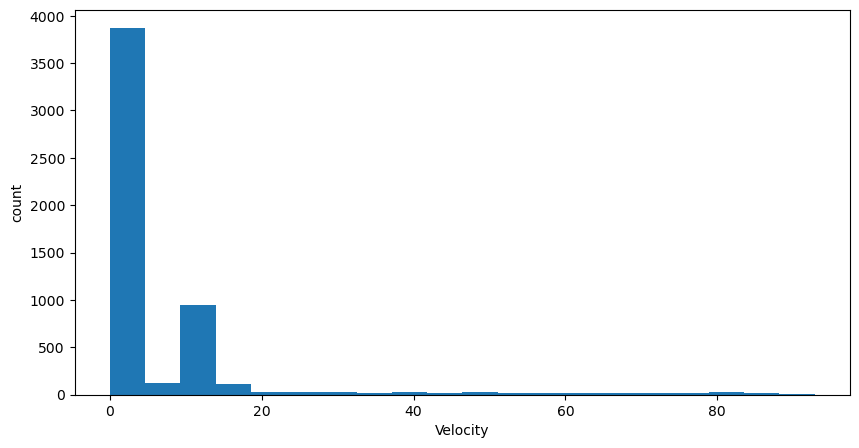

In [37]:
fig, ax = plt.subplots()
ax.hist(v['velocity'], bins =20)
ax.set(xlabel='Velocity', ylabel='count');

## Filter non-moving particles (zero velocities)

In [38]:
t7 = v.copy()
filtered_v = t7[t7['velocity']> 25]
print(filtered_v)

      frame  particle       x_ave       y_ave        dx        dy   velocity   
265       5        67  449.298315  113.246459 -1.133791  1.106436  26.751828  \
272       5        41  419.859920  165.796371  1.734031  0.262083  29.614573   
313       6        75   49.394965   37.661894 -4.216414  2.877484  86.201540   
317       6        67  447.571156  112.862843 -1.727159 -0.383616  29.876699   
382       7        85  561.236375  238.421242 -1.579001  0.303377  27.151744   
...     ...       ...         ...         ...       ...       ...        ...   
6255    125       483  516.033908  412.115188 -1.478412 -0.962098  29.786352   
6211    125       484   21.610351   60.399503 -0.299552  4.090954  69.267529   
6292    126       445  267.953875  330.073000 -1.724278  3.329808  63.321073   
6305    126       483  514.490843  411.426923 -1.543065 -0.688265  28.531756   
6261    126       484   20.981177   64.472161 -0.629173  4.072659  69.589477   

           angle  movement_angle  
265 

## Plot Filtered Velocities

Text(0.5, 1.0, 'Cell Velocities')

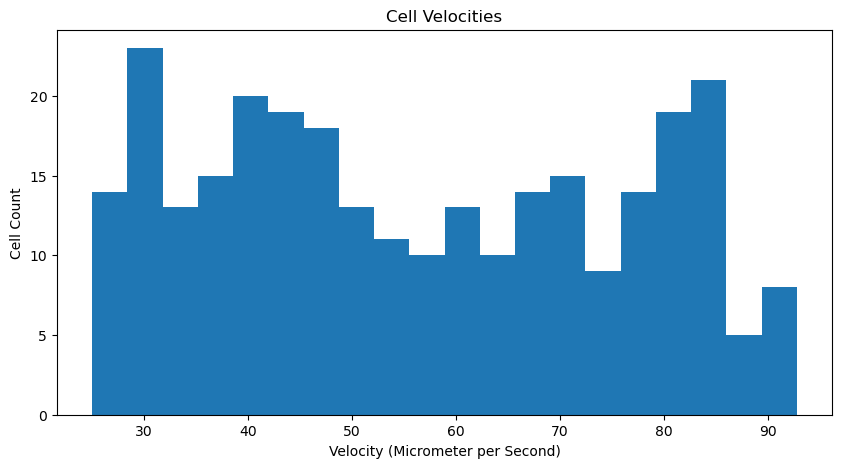

In [39]:
fig, ax = plt.subplots()
ax.hist(filtered_v['velocity'], bins =20)
ax.set(xlabel='Velocity (Micrometer per Second)', ylabel='Cell Count');
ax.set_title('Cell Velocities')

In [40]:
filtered_v.to_excel(excel_file, sheet_name='Filtered Velocity and Angle', index=False)

In [41]:
print(filtered_v)

      frame  particle       x_ave       y_ave        dx        dy   velocity   
265       5        67  449.298315  113.246459 -1.133791  1.106436  26.751828  \
272       5        41  419.859920  165.796371  1.734031  0.262083  29.614573   
313       6        75   49.394965   37.661894 -4.216414  2.877484  86.201540   
317       6        67  447.571156  112.862843 -1.727159 -0.383616  29.876699   
382       7        85  561.236375  238.421242 -1.579001  0.303377  27.151744   
...     ...       ...         ...         ...       ...       ...        ...   
6255    125       483  516.033908  412.115188 -1.478412 -0.962098  29.786352   
6211    125       484   21.610351   60.399503 -0.299552  4.090954  69.267529   
6292    126       445  267.953875  330.073000 -1.724278  3.329808  63.321073   
6305    126       483  514.490843  411.426923 -1.543065 -0.688265  28.531756   
6261    126       484   20.981177   64.472161 -0.629173  4.072659  69.589477   

           angle  movement_angle  
265 

## Plot Directions of Cell Velocities

Text(0.5, 1.0, 'Directions of Cell Velocities')

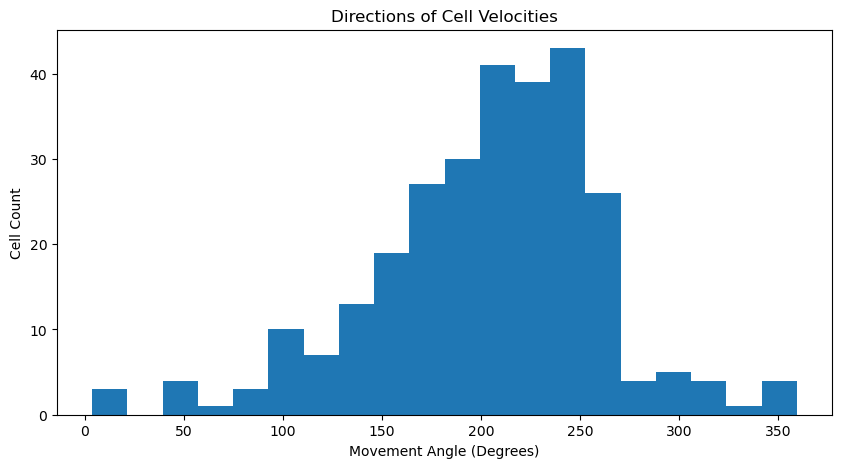

In [42]:
fig, ax = plt.subplots()
ax.hist(filtered_v['movement_angle'], bins =20)
ax.set(xlabel='Movement Angle (Degrees)', ylabel='Cell Count');
ax.set_title('Directions of Cell Velocities')

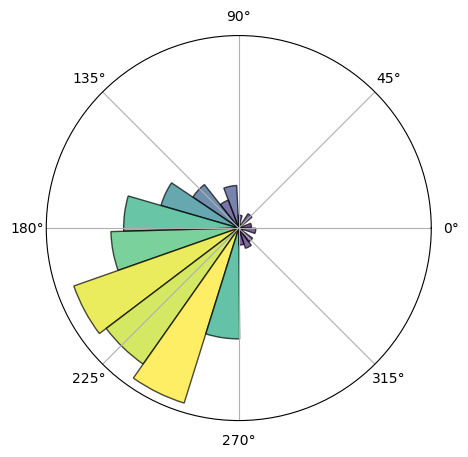

In [55]:
angles_rad = np.radians(filtered_v['movement_angle'])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
n, bins, patches = ax.hist(angles_rad, bins=20, density=True, edgecolor='black', alpha=0.7)

for patch in patches:
    patch.set_facecolor(plt.cm.viridis(patch.get_height() / max(n)))


ax.set_rlabel_position(0)
ax.set_rticks([])  

plt.show()

In [ ]:
excel_file.close()